In [1]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,SeparableConv2D,Conv1D, MaxPooling1D,SeparableConv1D
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
DATASETS_DIR = "../datasets_text/"
BASE_DIR ="../"

In [3]:
## ALL IMPORTANT FUNCTIONS
##--basis sets generation functioin
def generate_basis_sets(basis_path):
    generated_basis_sets =np.zeros((2048,22),dtype=complex)
    for i,m in enumerate(os.listdir(basis_path)):
        with open(os.path.join(METABOLITES_DIR,m)) as f:
            j=0
            for line in f.readlines()[22:]:
                line =line.strip()
                if line:
                    data =line.split()
                    m_real,m_imag = data[0],data[1]
                    m_sig =complex(float(m_real),float(m_imag))
                    generated_basis_sets[j,i] =m_sig
                j=j+1
        f.close()
    return np.asarray(generated_basis_sets)

##--mrs signals generation function
def generate_data(data_list):
    generated_data =np.zeros((2048,28),dtype=complex)
    for i,fname in enumerate(data_list):
        with open(os.path.join(DATASETS_DIR,fname)) as f:
            j=0
            for line in f:
                line = line.strip()
                if line:
                    data = line.split()
                    real_part = data[0]
                    imag_part =data[1]
                    complex_signal = complex(float(real_part),float(imag_part))
                    generated_data[j,i]=complex_signal
                j = j+1
        f.close()
    return generated_data

##--fourier transformation function
def td_2_fd(samples):
    f_domain = []
    for a in np.arange(samples.shape[1]):
        fft_data =np.fft.fft(samples[:,a])
        f_domain.append(fft_data)
    return np.asarray(f_domain)

##-- normalization function of the amplitudes
def normalize_ffts(ffts):
    for i in np.arange(ffts.shape[1]):
        ffts[:,i] -= ffts[:,i].mean()
        ffts[:,i] /= ffts.std()
    return ffts

## generating fake concentrations of my simulated datasets
def fake_concentrations():
    concentrations = np.zeros((22,28), dtype=float)
    for i in np.arange(22):
        for j in np.arange(28):
            concentrations[i,j] = np.random.choice(10)
    return concentrations

In [4]:
# metabolite basis sets
METABOLITES_DIR ="../basis_sets/"
bm = generate_basis_sets(METABOLITES_DIR)
bm_ffts  = td_2_fd(bm)
bm_ffts = bm_ffts.T
Y = normalize_ffts(bm_ffts)
Y.shape

(2048, 22)

/home/dronny/anaconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


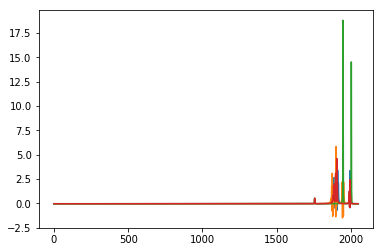

In [5]:
plt.plot(Y[:,1:5])

In [6]:
# mrs signal samples
datasets = os.listdir(DATASETS_DIR)
del datasets[1]
samples = generate_data(datasets)
samples_ffts  = td_2_fd(samples)
samples_ffts = samples_ffts.T
X = normalize_ffts(samples_ffts)
X.shape

(2048, 28)

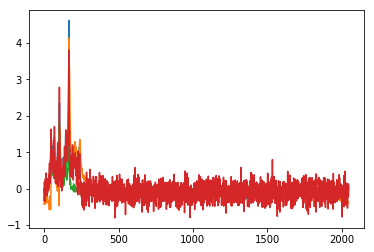

In [7]:
plt.plot(X[:,1:5])

In [8]:
from keras import backend as K
K.set_image_dim_ordering('th')

def get_model():
    model = Sequential()
    model.add(Conv1D(16, (2,),input_shape=(2048,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(32, (3,)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(64, (3,)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(128, (3,)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(22))
    
    model.compile(loss='mean_squared_error',
                optimizer='Adam',
                metrics=['accuracy'])
    return model

In [9]:
def get_model_2():
    model_2 = Sequential()
    model_2.add(SeparableConv1D(16, (2,),input_shape=(2048,1)))
    model_2.add(Activation('relu'))
    model_2.add(MaxPooling1D(pool_size=2))
    
    model_2.add(SeparableConv1D(32, (3,)))
    model_2.add(Activation('relu'))
    model_2.add(MaxPooling1D(pool_size=2))
    
    model_2.add(SeparableConv1D(64, (3,)))
    model_2.add(Activation('relu'))
    model_2.add(MaxPooling1D(pool_size=2))
    
    model_2.add(SeparableConv1D(128, (3,)))
    model_2.add(Activation('relu'))
    model_2.add(MaxPooling1D(pool_size=2))
    
    model_2.add(Flatten())
    model_2.add(Dense(22))
    
    model_2.compile(loss='mean_squared_error',
                optimizer='Adam',
                metrics=['accuracy'])
    return model_2

In [10]:
##Data splitting
## 80% training -- 20% testing

X_train ,X_test = train_test_split(X.T,test_size =0.2, random_state =10)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
#Y_test = np.reshape(Y_test, (Y_test.shape[0],Y_test.shape[1], 1))

X_train.shape

(22, 2048, 1)

In [19]:
concs =fake_concentrations()
Y_train ,Y_test = train_test_split(concs.T,test_size =0.2, random_state =10)
Y_train.shape, Y_test.shape

((22, 22), (6, 22))

In [20]:
early_stopping_monitor = EarlyStopping(patience=3)
model = get_model()
history =model.fit(X_train,Y_train, epochs=50,validation_split =0.2,callbacks=[early_stopping_monitor])

Train on 17 samples, validate on 5 samples
Epoch 1/50
17/17 [==============================] - 1s 85ms/step - loss: 29.2226 - acc: 0.0588 - val_loss: 25.8214 - val_acc: 0.0000e+00
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 24.6906 - acc: 0.0588 - val_loss: 20.0210 - val_acc: 0.0000e+00
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 19.7470 - acc: 0.0588 - val_loss: 14.5146 - val_acc: 0.0000e+00
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 18.2122 - acc: 0.0588 - val_loss: 12.2951 - val_acc: 0.0000e+00
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 19.5233 - acc: 0.0000e+00 - val_loss: 12.3235 - val_acc: 0.0000e+00
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 18.3122 - acc: 0.0000e+00 - val_loss: 12.8899 - val_acc: 0.0000e+00
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 16.2742 - acc: 0.0000e+00 - val_loss: 13.6503 - val_acc: 0.0

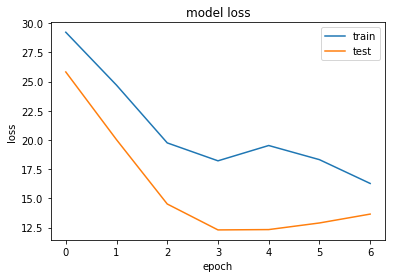

<Figure size 432x288 with 0 Axes>

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('model_loss_50epochs.png')

In [22]:
firstModel = get_model()
firstModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 2047, 16)          48        
_________________________________________________________________
activation_17 (Activation)   (None, 2047, 16)          0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 1023, 16)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1021, 32)          1568      
_________________________________________________________________
activation_18 (Activation)   (None, 1021, 32)          0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 510, 32)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 508, 64)           6208      
__________

In [41]:
# testing model i
# using cross validation
X_test = np.reshape(X_test, (X_test.shape[1],X_test.shape[0]))
X_test[

array([-0.01480299+0.91291488j,  0.06631926+1.61562793j,
        0.12646271+0.5820393j , -0.33024264+0.63741801j,
        0.01538471+1.55717749j, -0.06031172+1.43008848j])

In [23]:
secondModel = get_model_2()
secondModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d_1 (Separabl (None, 2047, 16)          34        
_________________________________________________________________
activation_21 (Activation)   (None, 2047, 16)          0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 1023, 16)          0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 1021, 32)          592       
_________________________________________________________________
activation_22 (Activation)   (None, 1021, 32)          0         
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 510, 32)           0         
_________________________________________________________________
separable_conv1d_3 (Separabl (None, 508, 64)           2208      
__________

In [24]:
early_stopping_monitor = EarlyStopping(patience=3)
history =secondModel.fit(X_train,Y_train,epochs=50,validation_split =0.2,callbacks=[early_stopping_monitor]) 

Train on 17 samples, validate on 5 samples
Epoch 1/50
17/17 [==============================] - 1s 42ms/step - loss: 29.6607 - acc: 0.0000e+00 - val_loss: 30.1427 - val_acc: 0.0000e+00
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 29.5041 - acc: 0.0000e+00 - val_loss: 29.9010 - val_acc: 0.0000e+00
Epoch 3/50
17/17 [==============================] - 0s 3ms/step - loss: 29.2545 - acc: 0.0000e+00 - val_loss: 29.5067 - val_acc: 0.0000e+00
Epoch 4/50
17/17 [==============================] - 0s 3ms/step - loss: 28.8557 - acc: 0.0588 - val_loss: 28.9193 - val_acc: 0.0000e+00
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 28.2694 - acc: 0.0000e+00 - val_loss: 28.1158 - val_acc: 0.0000e+00
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 27.4747 - acc: 0.0000e+00 - val_loss: 27.0811 - val_acc: 0.2000
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 26.4591 - acc: 0.0588 - val_loss: 25.8143 - val_acc:

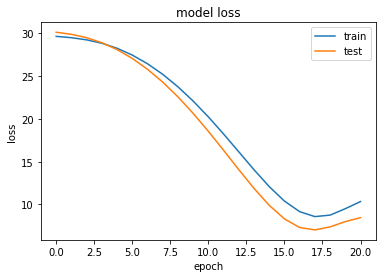

<Figure size 432x288 with 0 Axes>

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('model2_loss_50epochs.png')